In [1]:
knitr::opts_chunk$set(echo = TRUE)

# Introduction

Airbnb, a P2P online platform which provides accommodation for traveling guests, has become one of the biggest players in the hospitality industry and a reliable source of
income for many others all over the world.

From previous studies regarding the effects of different accommodation attributes
on rental prices for Airbnb properties, we know that location plays an important role on the price of Airbnb listings. In this study, in addition to location factors, we want to look at other factors which can be controlled by hosts, such as cleanliness of the room, communication with guests, check-in experience, accuracy of listing description, and their potential effects on prices. The factors described are measured by a host’s review scores^[ average scores for each category is a number from 1(worst) to 5(best)]
left by previous guests, which can be seen publicly
by potential bookers. We hope to find out whether there is a tendency or ability
for hosts to charge higher prices given their efforts in preparation(cleanliness), honesty(accuracy), communication, and hospitality(check-in experience)? We hope to use
our findings to help hosts understand the impact of their hosting efforts on their ability to charge higher
prices and help them make informed decisions on pricing strategies.



In [2]:

set.seed(1)

library(readr)
library(dplyr)
library(tidyverse)
all_listings <- read_csv("listings.csv")

dollar_regex <- "\\$"

clean1 <- all_listings%>%
  filter(room_type == "Private room",
         number_of_reviews >= 50,
         bedrooms == 1,
         )%>%
  mutate(price = stringr::str_remove(price, dollar_regex))%>%
  mutate_at("price", as.numeric)%>%
  dplyr::select(listing_url = listing_url,
                property_type = property_type,
                price = price,
                score_overall = review_scores_rating,
                score_value = review_scores_value,
                score_cleanliness = review_scores_cleanliness,
                score_accuracy = review_scores_accuracy,
                score_location = review_scores_location,
                score_communication = review_scores_communication,
                score_checkin = review_scores_checkin,
                accommodates = accommodates,
                bedrooms = bedrooms,
                beds = beds)

train <- clean1[sample(1:nrow(clean1), 430, replace = F),]
test <- clean1[which(!(clean1$listing_url %in% train$listing_url)),]





Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Rows: 16116 Columns: 74
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (24): listing_url, name, description, neighborhood_overview, picture_ur...
dbl  (37): id, scrape_id, host_id, host_listings_count, host_total_listings_...
lgl   (8): host_is_superhost, host_

# Methods

## Variable Selection

In context of the research question, the variables we choose are specific to factors related to hosting experience that can be controlled by Airbnb hosts. In addition to location, which is backed by research to have significant positive effect on prices[1], our full model will include:

- Price: price per night in Euros.

- location score: accessibility and how well the place is located.

- cleanliness score: cleanliness of the place.

- communication score: How well did the host communicates with their guests.

- check-in score: Check-in experience. 

- accuracy score: Was it accurately represented with up-to-date photos and info?

Goal: We are hoping to include all of the above variables in our final model to see which of them have significant effects on price. The primary goal is to construct a model where our T-tests and estimated coefficients are reliable, accurate, and representative of the population. Therefore, the "best" model will ideally have good model assumptions and low degree of collinearity(VIF); Goodness of fit(AIC, corrected AIC, BIC, adjusted $R^2$) will be of secondary importance. 

*In this study, we will only include listings which have reviews of over 50 because we want to look at experienced Airbnb hosts and their pricing strategies, rather than hosts who just started their Airbnb business and are playing around with different pricing strategies.

## Model Violations & Diagnostics
Starting with the full model, we will perform a EDA to forcast any potential problems. Then we will make predictor
vs. predictor plots, $Y vs. \hat{Y}$ plot to see if condition 1 and 2 hold. Specifically, we are looking for linear
relationships between predictors. Points should be spread evenly along the diagonal line in $Y vs. \hat{Y}$ plot. Then, we will check residual plots to see if linearity assumption, uncorrelated errors assumption, and constant variance assumption hold. Specifically, we are looking for random scattered points around 0. eg. no curves, fanning out pattern, and no large clusters of residuals that have obvious separation from the rest. Lastly, we will check the normality assumption. We are looking for a straight diagonal string of points with minimal deviations at the ends. If any of the conditions or assumptions are not satisfied, we will use box-cox transformation or other variable transformation to try and correct them.

## Problematic Observations

We will check for problematic observations: leverage points, outliers, and influential points using measures like $h_{ii}, r_i$, Cook's distance, DFFITS, DFBETAS. We are looking for points whose measures exceed the cutoffs. Those influential points may negatively impact the validity and accuracy of our model predictions and population descriptions. We will look at them and see if there are any reasons to remove them, such as measurement or recording error.

## Auto Selection Methods

1. Starting with the full model after variable transformations, we will use the all possible subsets method to fit the "best" models(in terms of adjusted $R^2$) of different number of predictors. We will choose the best 5 models for models of different sizes, eg. top 5 models with two predictors, three predictors, and so on. This way, we get to examine different models with different combinations of predictors without penalizing and eliminating the ones with relatively lower $R^2$ but possibly have better model assumptions and lower VIF's. We will also use auto selection methods for backward, forward, step-wise approaches using measure of AIC and BIC and use them as our potential models.

2. With all the possible models, we will start by eliminating the ones with very high collinearity(VIF values) and the ones with bad model assumptions.

3. We will then compare AIC, corrected AIC, BIC, adjusted $R^2$ for the models with relatively good model assumptions and low VIF's, and eliminate the ones with high AIC, corrected AIC, BIC values and low adjusted R^2(generally bad fit of model for data).

4. Lastly, with the remaining models, we will select our final model based on how well it does overall in terms of degree of collinearity, model assumptions, and goodness of fit using measures previously mentioned.

## Model Validation

Data will be split randomly to a 1:1 ratio without replacement. We will use the training dataset to perform model building and diagnostics. The test dataset will be used to validate our final model.

We will begin by performing a small EDA to check if there are major differences in the two datasets in terms of their means and standard deviations. If the difference is big, then it can potentially be the reason we cannot validate our models.

After we have our final model, we will compare it to the same model fit on the test dataset. We are hoping to see similar properties. Specifically, we are hoping to see minimal differences in the estimated coefficients, p-values, same predictors appearing as significant, minimal changes in model assumptions, similar residual sum of squares($RSS$), and adjusted $R^2$. We do not want to see new, or worse model violations. The differences in estimated coefficients should be within two standard errors of coefficients in the training data.
 


Call:
lm(formula = price ~ score_cleanliness + score_accuracy + score_location + 
    score_communication + score_checkin, data = train)

Residuals:
   Min     1Q Median     3Q    Max 
-67.50 -22.76  -5.58  12.63 434.17 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)          -170.11      87.77  -1.938 0.053265 .  
score_cleanliness      19.21      14.90   1.289 0.197988    
score_accuracy       -113.53      31.21  -3.637 0.000309 ***
score_location         67.79      11.21   6.049 3.19e-09 ***
score_communication    27.23      29.36   0.928 0.354142    
score_checkin          53.45      32.33   1.653 0.099010 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 42.2 on 424 degrees of freedom
Multiple R-squared:  0.1043,	Adjusted R-squared:  0.09378 
F-statistic: 9.879 on 5 and 424 DF,  p-value: 5.985e-09


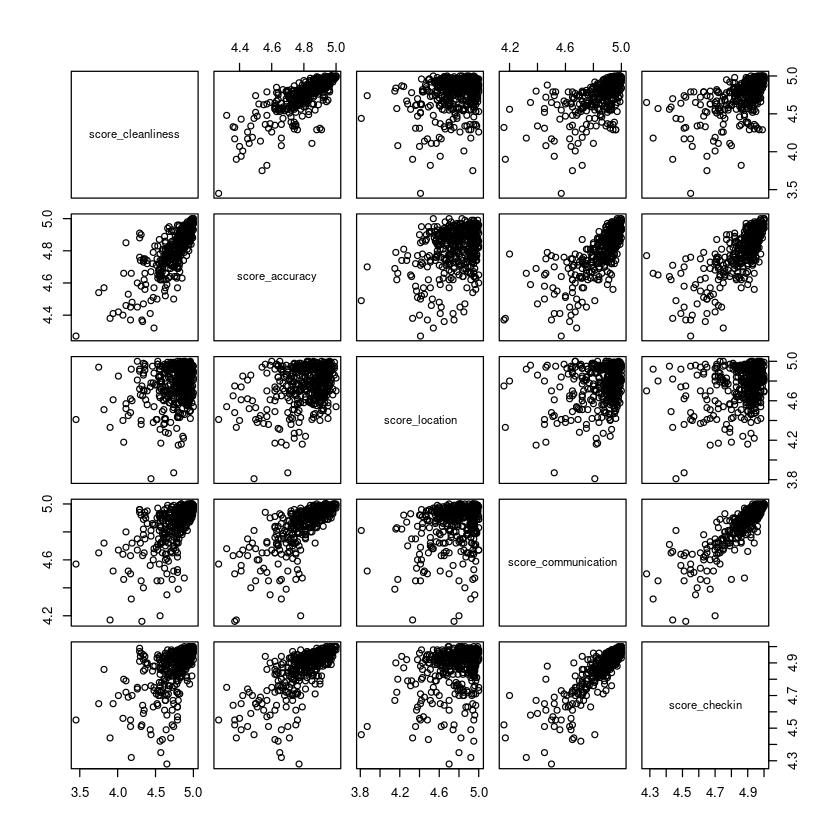

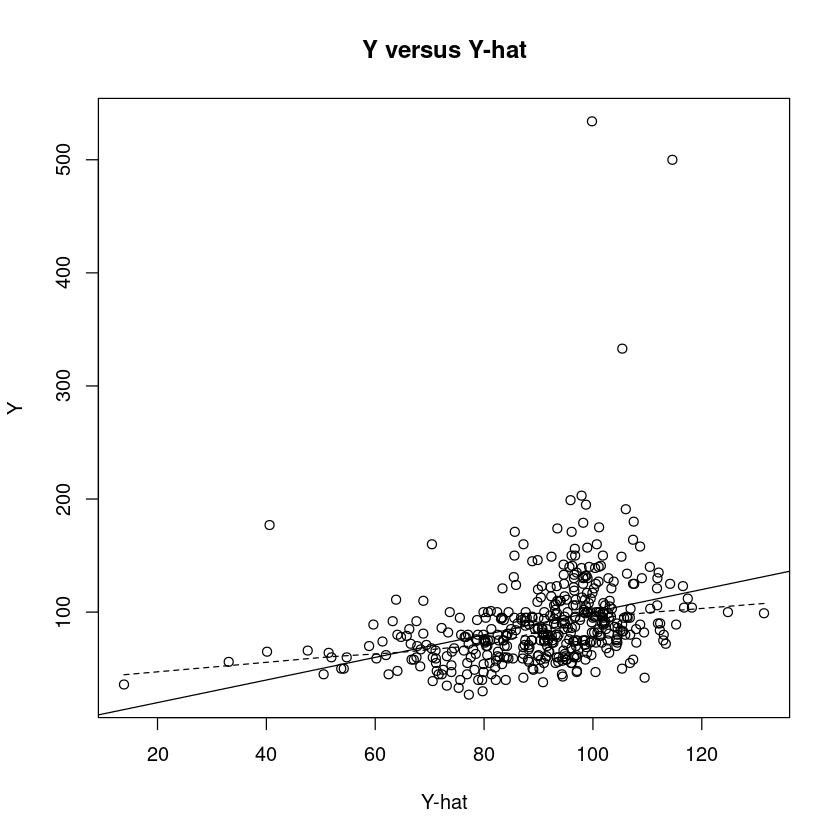

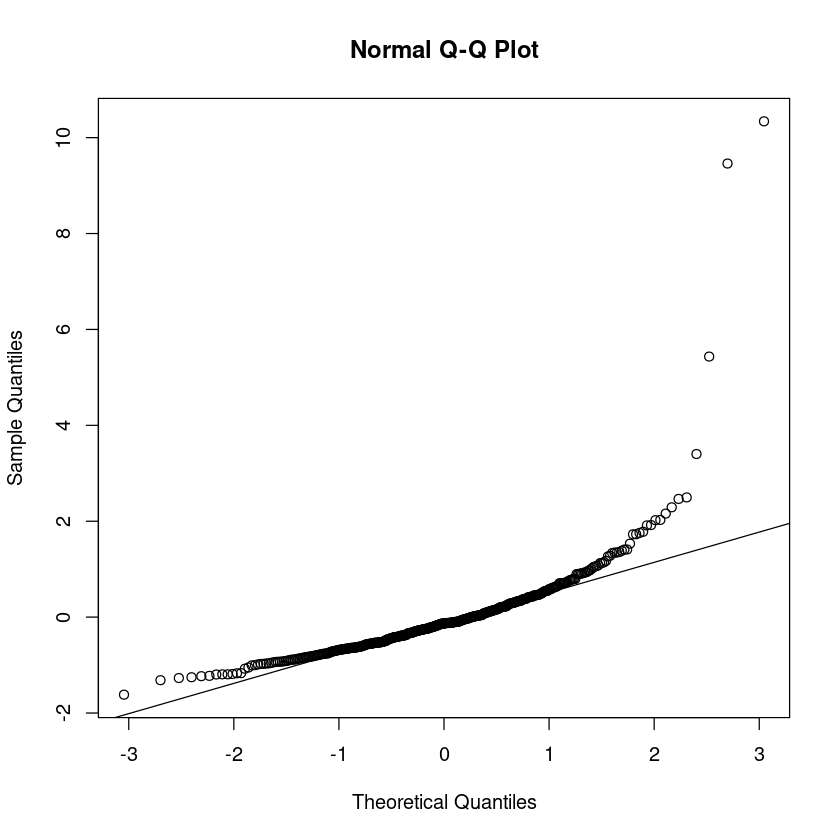

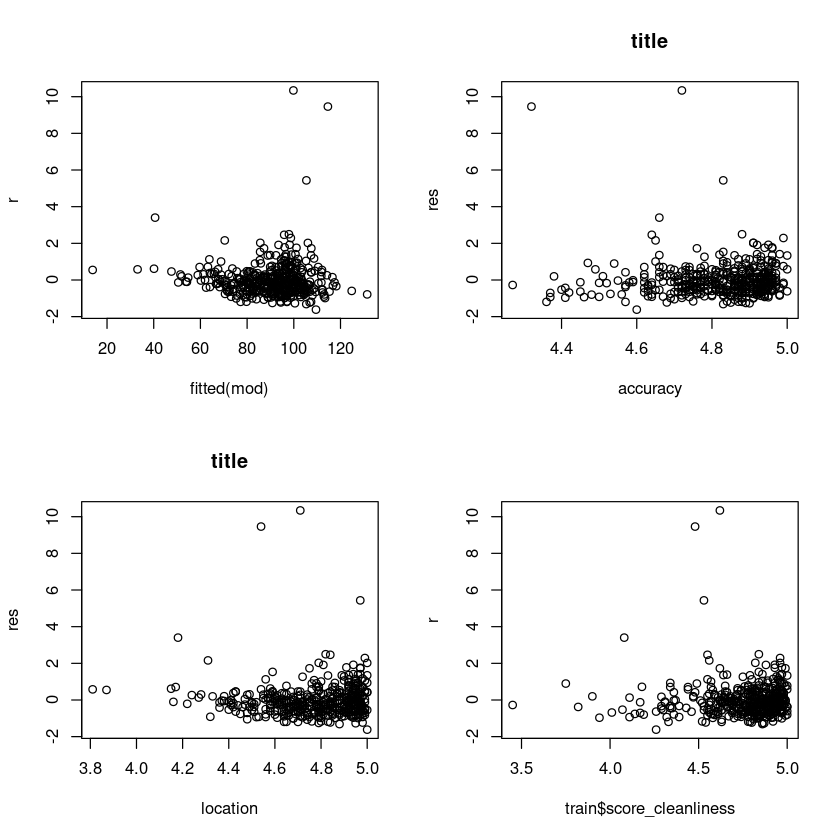

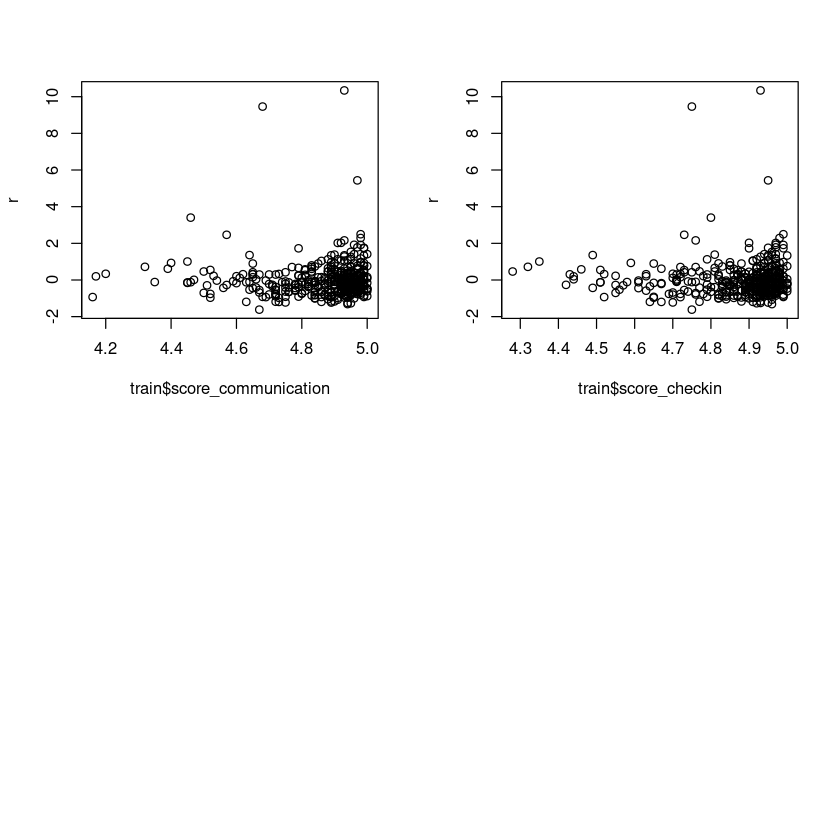

In [3]:

mod <- lm(price ~ score_cleanliness + score_accuracy + score_location + score_communication + score_checkin, data = train)
summary(mod)


# condition 2
pairs(train[6:10])

# condition 1
plot(train$price ~ fitted(mod), main="Y versus Y-hat", xlab="Y-hat", ylab="Y")
abline(a = 0, b = 1)
lines(lowess(train$price ~ fitted(mod)), lty=2)

# normality
r <- rstandard(mod)
qqnorm(r)
qqline(r)


# residual plots
par(mfrow=c(2,2))
plot(r ~ fitted(mod))
plot(r ~ train$score_accuracy, main="title", xlab="accuracy", ylab="res")
plot(r ~ train$score_location, main="title", xlab="location", ylab="res")
plot(r ~ train$score_cleanliness)
plot(r ~ train$score_communication)
plot(r ~ train$score_checkin)



In [4]:
# all possible models

# p <- powerTransform(cbind(train[,3], train[6:10]), family = "bcnPower")
# summary(p)

# car package not working on jupyterhub because the version is old

train$t_response <- log(train$price)
test$t_response <- log(test$price)
train_data <- train[, -c(1:5, 11:13)]
test_data <- test[, -c(1:5, 11:13)]
head(train_data)
head(test_data)

library(MASS)
## k = 2 is AIC, k = log(n) is BIC
##########################################################

# AIC
## forward selection 
stepAIC(lm(t_response ~ 1, data = train_data), scope = list(upper=lm(t_response ~ ., data = train_data)), direction = "forward", k = 2)
## backward selection
stepAIC(lm(t_response ~ ., data = train_data), scope = list(lower=lm(t_response ~ 1, data = train_data)), direction = "backward", k = 2)
## stepwise
stepAIC(lm(t_response ~ ., data = train_data), direction = "both", k = 2)


# same model

AIC_best <- lm(formula = t_response ~ score_cleanliness + score_accuracy + 
    score_location + score_checkin, data = train_data)
summary(AIC_best)
vif(AIC_best)

###########################################################

# BIC
# forward
stepAIC(lm(t_response ~ 1, data = train_data), scope = list(upper=lm(t_response ~ ., data = train_data)), direction = "forward", k = log(nrow(train_data)))
# backward
stepAIC(lm(t_response ~ ., data = train_data), scope = list(upper=lm(t_response ~ 1, data = train_data)), direction = "backward", k = log(nrow(train_data)))
# stepwise
stepAIC(lm(t_response ~ ., data = train_data), direction = "both", k = log(nrow(train_data)))

# results

#forward
BIC_forward <- lm(formula = t_response ~ score_location, data = train_data)
summary(BIC_forward)

#backward
BIC_backward <- lm(formula = t_response ~ score_cleanliness + score_accuracy + 
    score_location, data = train_data)
summary(BIC_backward)
vif(BIC_backward)

score_cleanliness,score_accuracy,score_location,score_communication,score_checkin,t_response
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.67,4.63,4.64,4.72,4.83,4.060443
4.87,4.74,4.22,4.82,4.94,4.060443
4.36,4.56,4.97,4.94,4.94,4.595120
4.63,4.86,4.74,4.91,4.96,3.737670
4.98,4.89,4.68,4.99,4.94,4.477337
4.79,4.77,4.50,4.83,4.92,4.317488


score_cleanliness,score_accuracy,score_location,score_communication,score_checkin,t_response
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.89,4.94,4.97,4.94,4.97,4.317488
4.89,4.90,4.95,4.85,4.87,4.770685
4.73,4.57,4.55,4.81,4.80,4.317488
4.83,4.83,4.29,4.83,4.88,3.688879
4.72,4.83,4.76,4.87,4.90,4.007333
4.69,4.80,4.69,4.89,4.85,3.871201



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select




Start:  AIC=-841.48
t_response ~ 1

                      Df Sum of Sq    RSS     AIC
+ score_location       1    9.8463 50.627 -915.90
+ score_checkin        1    1.4214 59.052 -849.71
+ score_communication  1    1.2027 59.271 -848.12
+ score_cleanliness    1    0.6302 59.843 -843.98
+ score_accuracy       1    0.4842 59.989 -842.94
<none>                             60.474 -841.48

Step:  AIC=-915.9
t_response ~ score_location

                      Df Sum of Sq    RSS     AIC
<none>                             50.627 -915.90
+ score_accuracy       1  0.142536 50.485 -915.11
+ score_checkin        1  0.105137 50.522 -914.79
+ score_communication  1  0.096158 50.531 -914.71
+ score_cleanliness    1  0.000898 50.626 -913.90



Call:
lm(formula = t_response ~ score_location, data = train_data)

Coefficients:
   (Intercept)  score_location  
         0.695           0.783  


Start:  AIC=-918.99
t_response ~ score_cleanliness + score_accuracy + score_location + 
    score_communication + score_checkin

                      Df Sum of Sq    RSS     AIC
- score_communication  1    0.1330 49.471 -919.83
- score_checkin        1    0.1632 49.501 -919.57
<none>                             49.338 -918.99
- score_cleanliness    1    0.2587 49.597 -918.74
- score_accuracy       1    1.1388 50.477 -911.18
- score_location       1    9.3938 58.732 -846.05

Step:  AIC=-919.83
t_response ~ score_cleanliness + score_accuracy + score_location + 
    score_checkin

                    Df Sum of Sq    RSS     AIC
<none>                           49.471 -919.83
- score_cleanliness  1    0.2856 49.757 -919.36
- score_checkin      1    0.7527 50.224 -915.34
- score_accuracy     1    1.0208 50.492 -913.05
- score_location     1    9.3186 58.790 -847.62



Call:
lm(formula = t_response ~ score_cleanliness + score_accuracy + 
    score_location + score_checkin, data = train_data)

Coefficients:
      (Intercept)  score_cleanliness     score_accuracy     score_location  
           0.7581             0.1882            -0.7272             0.8100  
    score_checkin  
           0.4957  


Start:  AIC=-918.99
t_response ~ score_cleanliness + score_accuracy + score_location + 
    score_communication + score_checkin

                      Df Sum of Sq    RSS     AIC
- score_communication  1    0.1330 49.471 -919.83
- score_checkin        1    0.1632 49.501 -919.57
<none>                             49.338 -918.99
- score_cleanliness    1    0.2587 49.597 -918.74
- score_accuracy       1    1.1388 50.477 -911.18
- score_location       1    9.3938 58.732 -846.05

Step:  AIC=-919.83
t_response ~ score_cleanliness + score_accuracy + score_location + 
    score_checkin

                      Df Sum of Sq    RSS     AIC
<none>                             49.471 -919.83
- score_cleanliness    1    0.2856 49.757 -919.36
+ score_communication  1    0.1330 49.338 -918.99
- score_checkin        1    0.7527 50.224 -915.34
- score_accuracy       1    1.0208 50.492 -913.05
- score_location       1    9.3186 58.790 -847.62



Call:
lm(formula = t_response ~ score_cleanliness + score_accuracy + 
    score_location + score_checkin, data = train_data)

Coefficients:
      (Intercept)  score_cleanliness     score_accuracy     score_location  
           0.7581             0.1882            -0.7272             0.8100  
    score_checkin  
           0.4957  



Call:
lm(formula = t_response ~ score_cleanliness + score_accuracy + 
    score_location + score_checkin, data = train_data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.00728 -0.20110 -0.01547  0.19566  1.82632 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)        0.75813    0.70959   1.068  0.28594    
score_cleanliness  0.18823    0.12016   1.566  0.11798    
score_accuracy    -0.72720    0.24557  -2.961  0.00324 ** 
score_location     0.80999    0.09053   8.947  < 2e-16 ***
score_checkin      0.49567    0.19492   2.543  0.01135 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3412 on 425 degrees of freedom
Multiple R-squared:  0.1819,	Adjusted R-squared:  0.1742 
F-statistic: 23.63 on 4 and 425 DF,  p-value: < 2.2e-16


ERROR: Error in vif(AIC_best): could not find function "vif"


# Results

## Description of Data & EDA

### Figure 1: Histograms of Response and Predictors

In [ ]:
par(mfrow=c(2,3))
hist(train$price, breaks = 20,main = "Histogram of Prices", xlab = "Price")
hist(train$score_cleanliness, breaks = 12,main = "Histogram of Cleanliness", xlab = "Cleanliness Score")
hist(train$score_accuracy, breaks = 12,main = "Histogram of Accuracy", xlab = "Accuracy Score")
hist(train$score_location, breaks = 12,main = "Histogram of Location", xlab = "Location Score")
hist(train$score_communication, breaks = 12,main = "Histogram of Communication", xlab = "Communication Score")
hist(train$score_checkin, breaks = 12,main = "Histogram of Checkin", xlab = "Checkin Score")

Distribution of the response, price, is approximately normal, albeit right skewed, so normality assumption may be violated. There are some observations on the right end which are very different from the rest and could be influential points which may negatively impact the accuracy of our estimated coefficients and other model results. All of the predictors are left-skewed which could lead to non-linearity. Transformations on these variables might also be needed to correct possible violated assumptions. In general, there do not appear to be any significant problems with our variables.

\newpage

## Steps and Proccess of Obtaining Final Model

Starting with the full model:

$price = \beta_0 + \beta_1Location + \beta_2Cleanliness + \beta_3Accuracy + \beta_4Communication + \beta_5Checkin + \epsilon$

### 1. Checking conditions & assumptions

For the full model, the two conditions seem to be satisfied. We did not observe weird non-linear relationships between predictors. As well, a transformation on the response variable can be applied to fix condition 1. Normality assumption does not seem to be satisfied as there were significant lift of points in the right tail of our QQ plot. Residual plots will be checked after variable transformations.

### 2. Variable transformations

We did not use the box-cox transformations outputted by R as they did not improve the conditions and assumptions for our model. Condition 1 improved a lot but the normality assumption did not. There were significant lifts on both ends of the tails in our QQ plot.

The transformation that improved our model assumptions is a log transformation to our response. The transformed model is fitted as below. 

$log(price) = \beta_0 + \beta_1Location + \beta_2Cleanliness + \beta_3Accuracy + \beta_4Communication + \beta_5Checkin + \epsilon$

### 3. Checking Conditions & Model Assumptions of Transformed Model

### Figure 2: Conditions and Model Assumptions

In [ ]:

train$t_response <- log(train$price)
test$t_response <- log(test$price)

t_mod <- lm(t_response ~ score_cleanliness + score_accuracy + score_location + score_communication + score_checkin, data = train)

par(mfrow=c(1,2))

r <- rstandard(t_mod)
qqnorm(r)
qqline(r)

# condition 1
plot(log(train$price) ~ fitted(t_mod), main="Y versus Y-hat", xlab="Y-hat", ylab="Y")
abline(a = 0, b = 1)
lines(lowess(log(train$price) ~ fitted(t_mod)), lty=2)

# residual plots
par(mfrow=c(2,3))

plot(r ~ fitted(t_mod), main="Fitted Values vs. Residuals", xlab="accuracy", ylab="res")
plot(r ~ train$score_accuracy, main="Accuracy vs. Residuals", xlab="accuracy", ylab="res")
plot(r ~ train$score_location, main="Location vs. Residuals", xlab="location", ylab="res")
plot(r ~ train$score_cleanliness, main="Cleanliness vs. Residuals", xlab="Cleanliness", ylab="res")
plot(r ~ train$score_communication, main="Comm. vs. Residuals", xlab="Communication", ylab="res")
plot(r ~ train$score_checkin, main="Checkin vs. Residuals", xlab="Checkin", ylab="res")


Conditions 1 and 2 (see appendix, figure 1) are satisfied: points are spread evenly along the diagonal line in $Y vs. \hat{Y}$ plot and no observations of weird non-linear relationships between predictors. Residual plots also look good: points are randomly scattered like a cloud around 0. There are some lifts of points on the right end of our QQ plot, but normality assumption is still reasonably satisfied, though not perfect.

### 4. Check for leverage points, outliers, and influential points (see appendix section, figure 2) 

In [ ]:
## leverage points

head(train)
n <- length(train$price)
p <- length(coef(t_mod))-1
# calculate the leverage values and compare to cutoff
h <- hatvalues(t_mod)
hcut <- 2*(p+1)/n
# which observations are leverage points?
w1 <- which(h > hcut)
w1


# outliers

r_standard <- rstandard(t_mod)
# which observations are outliers?
w2 <- which(r_standard < -4 | r_standard > 4)
w2


Dcutoff <- qf(0.5, p+1, n-p-1)
D <- cooks.distance(t_mod)
which(D > Dcutoff)
## named integer(0)
# find the DFFITS and compare to cutoff
DFFITScut <- 2*sqrt((p+1)/n)
dfs <- dffits(t_mod)
w3 <- which(abs(dfs) > DFFITScut)
w3
## 44  66  88 106 124 148 149 163 174 221 223 

# find the DFBETAS and compare to cutoff (notice the dimension of DFBETAS)
DFBETAcut <- 2/sqrt(n)
dfb <- dfbetas(t_mod)

w4 <- which(abs(dfb[,1]) > DFBETAcut)
w4

w5 <- which(abs(dfb[,2]) > DFBETAcut)
w5

w6 <- which(abs(dfb[,3]) > DFBETAcut)
w6

w7 <- which(abs(dfb[,4]) > DFBETAcut)
w7

w8 <- which(abs(dfb[,5]) > DFBETAcut)
w8
w9 <- which(abs(dfb[,6]) > DFBETAcut)
w9
w <- unique(c(w3, w4, w5, w6, w7, w8, w9))
w


We have 430 observations in our training data set; we observed 47 leverage points, 3 outliers, and 44 unique influential points determined by measures of Cook's distance, DFFITS, and DFBETAS We did not remove any of them because they were not measurement or recording errors.

### 5. Using Auto Selection Methods To Fit Possible Models

In [ ]:
install.packages("leaps", repos = "http://cran.us.r-project.org")
library(leaps)

train$t_response <- log(train$price)
head(train)

## all subsets

best <- regsubsets(t_response ~ score_cleanliness + score_accuracy + score_checkin + score_communication + score_location, data = train, nbest = 5)
#
summary(best)

# subsets(best, statistic = "adjr2")


mod1<- lm(t_response ~  score_location, data = train)
mod12 <- mod1<- lm(t_response ~  score_accuracy, data = train)
mod21 <- lm(t_response ~ score_accuracy + score_location, data = train)
mod22 <- lm(t_response ~ score_checkin + score_location, data = train)
mod23 <- lm(t_response ~ score_communication + score_location, data = train)
mod24 <- lm(t_response ~ score_cleanliness + score_location, data = train)
mod31 <- lm(t_response ~ score_accuracy + score_communication + score_location, data = train)
mod32 <- lm(t_response ~ score_accuracy + score_checkin + score_location, data = train)
mod33 <- lm(t_response ~ score_accuracy + score_cleanliness + score_location, data = train)
mod34 <- lm(t_response ~ score_cleanliness + score_checkin + score_location, data = train)
mod35 <- lm(t_response ~ score_cleanliness + score_communication + score_location, data = train)
mod41 <- lm(t_response ~ score_cleanliness + score_accuracy + score_checkin + score_location, data = train)
mod42 <- lm(t_response ~ score_cleanliness + score_accuracy + score_communication + score_location, data = train)
mod43 <- lm(t_response ~ score_checkin + score_accuracy + score_communication + score_location, data = train)
mod44 <- lm(t_response ~ score_cleanliness + score_checkin + score_communication + score_location, data = train)
mod5 <- lm(t_response ~ score_cleanliness + score_accuracy + score_checkin + score_communication + score_location, data = train)

summary(mod1)

## all possible models
vif(mod21)
vif(mod22)
vif(mod23)
vif(mod24)
vif(mod31)
vif(mod32)
vif(mod33)
vif(mod34)
vif(mod35)
vif(mod41)
vif(mod42)
vif(mod43)
vif(mod44)
vif(mod5)

summary(mod33)
summary(mod34)
summary(mod41)
summary(mod42)

mod24test <- lm(t_response ~ score_cleanliness + score_location, data = test_data)
mod34test <- lm(t_response ~ score_cleanliness + score_checkin + score_location, data = test_data)
mod35test <- lm(t_response ~ score_cleanliness + score_communication + score_location, data = test_data)
mod41test <- lm(t_response ~ score_cleanliness + score_accuracy + score_checkin + score_location, data = test_data)
mod42test <- lm(t_response ~ score_cleanliness + score_accuracy + score_communication + score_location, data = test_data)


summary(mod24test)
summary(mod34test)
summary(mod35test)
summary(mod41test)
summary(mod42test)


# low VIF
vif(mod33) # 0.1592
vif(mod34) # 0.1591
vif(mod41) # 0.1742
vif(mod42) # 0.1737




### Figure 3: Performance of Selected Models

In [ ]:
mod <- c("1", "2", "3", "4")
predictor1_VIF <- c("1.128", "1.098", "1.131", "1.128")
predictor2_VIF <- c("2.665", "1.510", "2.667", "2.668")
predictor3_VIF <- c("2.824", "x", "4.095", "4.052")
predictor4_VIF <- c("x", "x", "x", "2.325")
predictor5_VIF <- c("x", "1.541", "2.235", "x")
adjusted_r2 <- c("0.164", "0.159", "0.174", "0.174")
AIC <- c("306.9", "309.2", "302.5", "302.7")
cAIC <- c("307.0", "309.3", "302.7", "302.9")
BIC <- c("327.3", "329.6", "326.8", "327.1")

cols <- data.frame(mod, predictor1_VIF, predictor2_VIF, predictor3_VIF, predictor4_VIF, predictor5_VIF, adjusted_r2, AIC, cAIC, BIC)

knitr::kable(cols, "pipe", col.names = c("Model", "Location VIF", "Cleanliness VIF", "Accuracy VIF", "Comm. VIF", "Checkin VIF", "Adjusted R.Sq", "AIC", "Corrected AIC", "BIC"))


We used the all possible subsets methods and other auto selection methods to produce 21 unique possible models. Due to the nature of our research question as well as very low adjusted $R^2$, we eliminated all the 1 and 2 predictor models. VIF values were a lot higher in the full model compared to others, so the full model was eliminated.

We selected the top 4 models measured by degrees of collinearity, conditions & assumptions, and goodness of fit. In general, all of them had relatively low VIF's, good model assumptions, and high $R^2$ compared to the rest.

### 6. Final Selection

In the end, we decided to go with model 3. We believe it was the best model because it had relatively low VIF values besides one of them being $> 4$, good model assumptions, relatively high adjusted $R^2$, and the lowest AIC, corrected AIC, and BIC values.

Final model: $log(price) = \beta_0 + \beta_1Location + \beta_2Cleanliness + \beta_3Accuracy  + \beta_4Checkin + \epsilon$

### 7. Conditions & Model Assumptions of Final Model

In [ ]:

# model assumptions mod41 !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
mod41 <- lm(t_response ~ score_cleanliness + score_accuracy + score_checkin + score_location, data = train)
r <- rstandard(mod41)
qqnorm(r)
qqline(r)
# condition 2
pairs(train_data[c(1,2,3,5)], lower.panel = NULL)
# condition 1
plot(log(train$price) ~ fitted(mod41), main="Y versus Y-hat", xlab="Y-hat", ylab="Y")
abline(a = 0, b = 1)
lines(lowess(log(train$price) ~ fitted(mod41)), lty=2)
# residual plots
par(mfrow=c(2,2))
plot(r ~ fitted(mod41))
plot(r ~ train$score_accuracy, main="title", xlab="accuracy", ylab="res")
plot(r ~ train$score_location, main="title", xlab="location", ylab="res")
plot(r ~ train$score_cleanliness, main="title", xlab="location", ylab="res")
plot(r ~ train$score_checkin, main="title", xlab="location", ylab="res")

summary(mod41)


Condition 1 and 2 are satisfied and residual plots look good. Hence, linearity, uncorrelated errors, and constant variance assumptions are satisfied. There are some lifts of points on both ends of the QQ plot, but normality is still reasonably satisfied. Overall, conditions and assumptions are satisfied. 

### 8. Model Interpretation & Importance

### Figure 4: Summary Statistics in Training and Test Dataset, each of size 430"

In [ ]:

coefficients <- c("(Intercept)", "Cleanliness", "Accuracy", "Checkin", "Location")
estimate <- c("0.758", "0.188", "-0.727", "0.496", "0.910")
sd <- c("0.710", "0.120", "0.246", "0.195", "0.091")
p <- c("0.286", "0.118", "0.00324*", "0.01135*", "2e-16*")

cols <- data.frame(coefficients, estimate, sd, p)

knitr::kable(cols, "pipe", col.names = c("Coefficients", "Estimate", "Std. Error", "Pr(>|t|)"), 
             caption = "Summary of Model (Training)")


We see that the T-test for variable, cleanliness, is not significant, which means how clean a room is might not have significant impact on its price. When all other variables are held constant, when accuracy score increases by 1, $log(price)$ decreases by 0.727. This indicates how accurate a listing is described with up-to-date photos and info has a negative impact on price. One possible explanation is when photos and information of a listing are "enhanced" or described better than it actually is, hence worse accuracy, Airbnb hosts tend to be able to charge more. When checkin score increases by 1, $log(price)$ increases by 0.496. This means hosts who provide better check-in experience for guests are able to charge more for their rooms. When location score is increased by 1, the $log(price)$ is increased by 0.810. This means when a listing is well-located, hosts are able to charge more. 

### 9. Model Validation

In [ ]:


# model assumptions mod41_test!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
mod41_test <- lm(t_response ~ score_cleanliness + score_accuracy + score_checkin + score_location, data = test_data)
r <- rstandard(mod41_test)
qqnorm(r)
qqline(r)
# condition 2
pairs(test_data[c(1,2,3,5)], lower.panel = NULL)
# condition 1
plot(test_data$t_response ~ fitted(mod41_test), main="Y versus Y-hat", xlab="Y-hat", ylab="Y")
abline(a = 0, b = 1)
lines(lowess(test_data$t_response ~ fitted(mod41_test)), lty=2)
# residual plots
par(mfrow=c(2,2))
plot(r ~ fitted(mod41_test))
plot(r ~ test_data$score_accuracy, main="title", xlab="accuracy", ylab="res")
plot(r ~ test_data$score_location, main="title", xlab="location", ylab="res")
plot(r ~ test_data$score_cleanliness, main="title", xlab="location", ylab="res")
plot(r ~ test_data$score_checkin, main="title", xlab="location", ylab="res")

vif(mod41_test)
AIC(mod41_test)
BIC(mod41_test)
summary(mod41)
summary(mod41_test)


### Figure 5: Model Comparisons: Training vs. Test

In [ ]:


Variable <- c("log(Price)", "Location", "Cleanliness", "Accuracy", "Communication", "Checkin")
mean_sd_train <- c("4.43(0.38)", "4.77(0.19)", "4.76(0.22)", "4.82(0.14)", "4.87(0.14)", "4.87(0.13)")
mean_sd_test <- c("4.42(0.39)", "4.76(0.20)", "4.79(0.21)", "4.83(0.13)", "4.87(0.13)", "4.88(0.12)")

cols <- data.frame(Variable, mean_sd_train, mean_sd_test)

knitr::kable(cols, "pipe", col.names = c("Variable", "Mean(s.d) in Training", "Mean(s.d) in Test"), caption = "Summary Statistics in Training and Test Datasets, each of size 430")

coefficients <- c("(Intercept)", "Cleanliness", "Accuracy", "Checkin", "Location")
estimate <- c("0.511", "0.450", "-0.895", "0.328", "0.937")
sd <- c("0.732", "0.127", "0.247", "0.214", "0.091")
p <- c("0.486", "0.000414*", "0.000330*", "0.126", "2e-16*")

cols <- data.frame(coefficients, estimate, sd, p)

knitr::kable(cols, "pipe", col.names = c("Coefficients", "Estimate", "Std. Error", "Pr(>|t|)"), 
             caption = "Summary of Model (Test)")

mod <- c("Training", "Test")
predictor1_VIF <- c("1.131", "1.163")
predictor2_VIF <- c("2.667", "2.472")
predictor3_VIF <- c("4.095", "3.809")
predictor4_VIF <- c("x", "x")
predictor5_VIF <- c("2.235", "2.386")
adjusted_r2 <- c("0.174", "0.237")
AIC <- c( "302.5", "309.8")
cAIC <- c("302.7", "310.3")
BIC <- c("326.8", "334.2")
RSS <- c("0.341", "0.344")

cols <- data.frame(mod, predictor1_VIF, predictor2_VIF, predictor3_VIF, predictor4_VIF, predictor5_VIF, adjusted_r2, AIC, cAIC, BIC, RSS)

par(mfrow=c(1,2))

knitr::kable(cols, "pipe", col.names = c("Model", "Location VIF", "Cleanliness VIF", "Accuracy VIF", "Comm. VIF", "Checkin VIF", "Adjusted R.sq", "AIC", "Corrected AIC", "BIC", "RSS"), 
             caption = "Model Properties: Test vs. Training")



Summary statistics in both datasets appear similar. Conditions and assumptions of the model for both training and test dataset are similar. There are more influential points in the test dataset than training: 66 vs. 46 respectively. RSS is similar at around 0.34. Adjusted R-squared are a bit different: 0.174 and 0.237 for training and test dataset respectively.

The predictor, cleanliness, is insignificant in the training dataset but significant in test dataset. On the other hand, checkin is significant in the training dataset but insignificant in the training dataset. The estimated coefficients of accuracy, location, checkin score, and the intercept are all within 2 standard deviations compared to the ones in test dataset. Due to the significant differences in T-tests and adjusted $R^2$, our final model is not validated.

\newpage

## Limitations

It is important to note that our results should be taken with a grain of salt because we had many influential points in our training dataset, normality assumption is not perfectly satisfied, and most importantly, our final model is not validated. Other transformations may have improved normality assumption but were ultimately not used because they jeopardized other conditions and assumptions. Our inability to validate the final model may be due to the differences in observations and large number of influential points in both datasets.

The large number of influential points and non-perfect normality assumption can introduce biases in our results, which means are the our T-tests for each estimated coefficients as well as the estimated coefficients themselves may not accurate and reliable. 

## References

1. Jorge Chica-Olmo, Juan Gabriel González-Morales, José Luis Zafra-Gómez,
Effects of location on Airbnb apartment pricing in Málaga,
Tourism Management,
Volume 77,
2020,
103981,
ISSN 0261-5177,
https://doi.org/10.1016/j.tourman.2019.103981.

## Appendix

### Figure 1: Predictor vs. Predictor Plots

In [ ]:

# condition 2

pairs(clean1[6:10])

### Figure 2: Influential Points in Predictor vs. Response Plots

In [ ]:
par(mfrow=c(2,3))
plot(train$t_response~train$score_cleanliness, main="Response vs Cleanliness", xlab="Cleanliness", ylab="log(Price)")
points(train$t_response[w] ~train$score_cleanliness[w], col="orange", pch=19)
plot(train$t_response~train$score_accuracy, main="Response vs accuracy", xlab="accuracy", ylab="log(Price)")
points(train$t_response[w] ~train$score_accuracy[w], col="orange", pch=19)
plot(train$t_response~train$score_location, main="Response vs location", xlab="location", ylab="log(Price)")
points(train$t_response[w] ~train$score_location[w], col="orange", pch=19)
plot(train$t_response~train$score_communication, main="Response vs communication", xlab="communication", ylab="log(Price)")
points(train$t_response[w] ~train$score_communication[w], col="orange", pch=19)
plot(train$t_response~train$score_checkin, main="Response vs checkin", xlab="checkin", ylab="log(Price)")
points(train$t_response[w] ~train$score_checkin[w], col="orange", pch=19)


### word count: 1695


















